# BL Lac blazars
A model for the luminosity function and cosmic evolution of BL Lac type blazars is presented in [Ajello et al. 2014](https://arxiv.org/abs/1310.0006), based on observations in gamma-rays with the Fermi-LAT instrument.

We can use the results of this paper to build a BL Lac population that is able to reproduce the results reported in the recent [4FGL Fermi-LAT catalog](https://arxiv.org/abs/1902.10045) reasonably well.

In [1]:
from scipy import special as sf
from astropy.coordinates import SkyCoord
from popsynth import (ZPowerCosmoDistribution, SoftFluxSelection,
                      GalacticPlaneSelection)
					  
from popsynth import SFRDistribution, BPLDistribution, PopulationSynth, NormalAuxSampler, AuxiliarySampler, HardFluxSelection

%matplotlib inline

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)
purple = "#B833FF"
yellow = "#F6EF5B"

import networkx as nx
import numpy as np
import warnings

warnings.simplefilter("ignore")


The work mentioned above presents 3 models for the BL Lac luminosity function. Here, we focus on the case of pure density evolution (referred to as PDE in the paper). In this case, the BL Lac population is parametrised as having a broken power law luminosity distribution, with an independent density evolution following a cosmological power law distribution.

We work with a luminosity range of $L_\mathrm{min} = 7\times 10^{43}$ erg $\mathrm{s}^{-1}$ and $L_\mathrm{max} = 10^{52}$ erg $\mathrm{s}^{-1}$ following Ajello et al. 2014. All luminosities are in units of erg $\mathrm{s}^{-1}$. Similarly, the maxium redshift considered in $z=6$.

We start by setting up the broken power law distribution (`BPLDistribution`).

Text(0.5, 0, 'L [erg $\\mathrm{s}^{-1}$]')

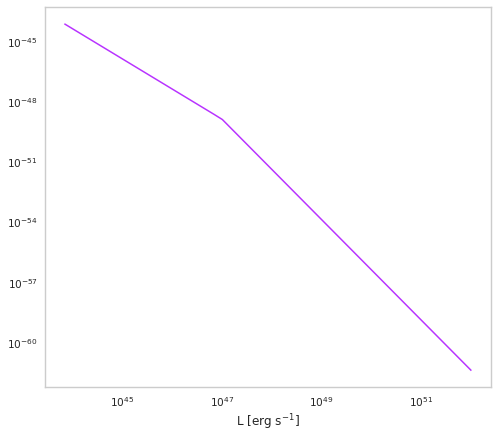

In [2]:
bpl = BPLDistribution()
bpl.alpha = -1.5
bpl.beta = -2.5
bpl.Lmin = 7e43
bpl.Lmax = 1e52
bpl.Lbreak = 1e47

fig, ax = plt.subplots()
L = np.geomspace(bpl.Lmin, bpl.Lmax)
ax.plot(L, bpl.phi(L), color=purple)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"L [erg $\mathrm{s}^{-1}$]")

We now move to the redshift distribution. Following the paper, we parametrize this as a negative power law in $z$. for the purpose of this example, we assume that Bl Lac blazars emit with a steady state. This means that we need to set the `is_rate` parameter to `False` when defining the `ZPowerCosmoDistribution` cosmological distribution. What we mean when we do this is that our local number density, `Lambda` is not per unit time. We also want to survey the whole sky, so we integrate over $4\pi$ sr in the value that we pass to the `Lambda`. 

Text(0, 0.5, '$\\frac{\\mathrm{d}N}{\\mathrm{d}V}$')

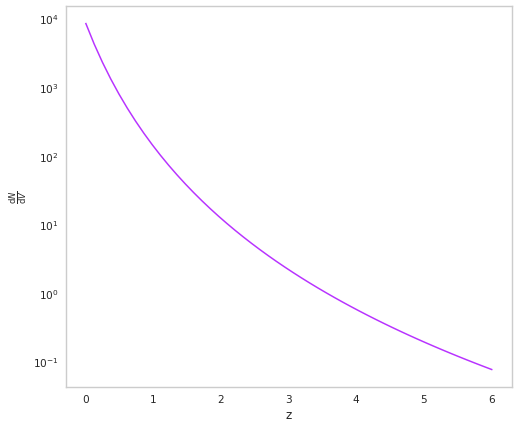

In [3]:
zpow = ZPowerCosmoDistribution(is_rate=False)
zpow.Lambda = 9000 # Gpc^-3 sr 
zpow.delta = -6

fig, ax = plt.subplots()
z = np.linspace(0.01, 6)
ax.plot(z, zpow.dNdV(z), color=purple)
ax.set_yscale("log")
ax.set_xlabel("z")
ax.set_ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}V}$")

Apart from their redshifts and luminosities, BL Lacs also have other properties. As a simple example, we can consider their spectral index, assuming that the gamma-ray emission is well modelled in the energy range of interest (0.1 to 100 GeV) by a simple power law. 

We assume these true values of these indices are normally distributed with mean, $\mu$, and standard deviation, $\tau$. Additionally, we recognise that these are reconstructed quantities in real surveys, with uncertain values. This is reflected in the error, $\sigma$, on the observed values.

In [4]:
index = NormalAuxSampler(name="index")
index.mu = 2.1
index.tau = 0.25
index.sigma = 0.1

We know that the Fermi-LAT detector cannot detect all objects in the Universe, and it is necessary to model some kind of selection function. In general, brighter and spectrally harder objects are easier to detect. We take this into acount by selecting on the flux, $F=L/4\pi d_L^2(z)$, where $d_L$ is the luminosity distance in cm.

This selection effect will not really be a hard boundary, although we could approximate it as such. In reality, the probability to detect an object increases as a function of its flux. To capture this effect, we consider a `SoftFluxSelection` as follows.

Text(0, 0.5, 'Detection prob.')

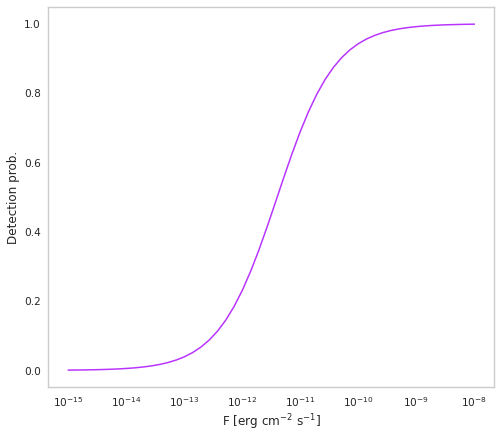

In [5]:
flux_selector = SoftFluxSelection()
flux_selector.boundary = 4e-12 # erg cm^-2 s^-1
flux_selector.strength = 2

# This is what is happening under the hood
fig, ax = plt.subplots()
F = np.geomspace(1e-15, 1e-8)
ax.plot(F, sf.expit(flux_selector.strength * (np.log10(F) - np.log10(flux_selector.boundary))), color=purple)
ax.set_xscale("log")
ax.set_xlabel("F [erg $\mathrm{cm}^{-2}$ $\mathrm{s}^{-1}$]")
ax.set_ylabel("Detection prob.")

Finally, sometimes it is harder to detect objects near the bright Galactic plane. We take this into account by excluding $10^\circ$ either side of the plane in Galactic longitude using the `GalacticPlaneSelector`.

In [6]:
gp = GalacticPlaneSelection()
gp.b_limit = 10

Now, lets finally bring all this together to make a simulated population. Here, we defined our luminosity and spatial distributions already, so we can use them directly in `PopulationSynth`, but there is also the `BPLZPowerCosmoPopulation` available as a quick interface.

In [7]:
# Main pop synth
pop_synth = PopulationSynth(spatial_distribution=zpow, luminosity_distribution=bpl)

# Add our selection effects
pop_synth.set_flux_selection(flux_selector)
pop_synth.add_spatial_selector(gp)

# Add our auxiliary param - spectral index
pop_synth.add_observed_quantity(index)

Lets run it! The last parameter to set is adding some uncertainty to our observed flux values.

In [8]:
population = pop_synth.draw_survey(flux_sigma=0.1)

Drawing distances:   0%|          | 0/9254 [00:00<?, ?it/s]

We can now have a look at the properties of this simulated population, such as the detected and undetected fluxes and distances.

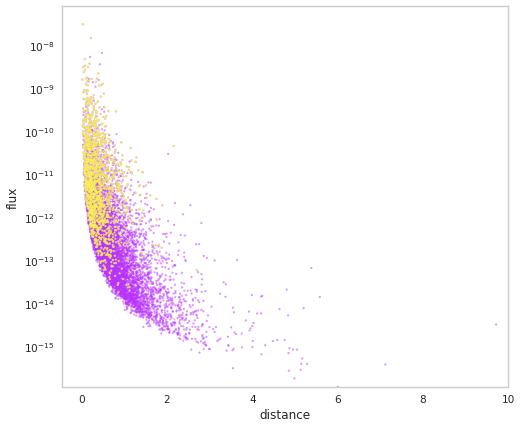

In [9]:
population.display_fluxes(true_color=purple, obs_color=yellow, with_arrows=False, s=5);

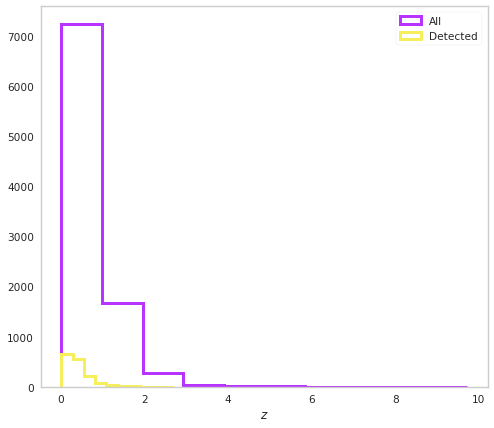

In [10]:
fig, ax = plt.subplots()
ax.hist(population.distances, color=purple, histtype="step", lw=3, label="All")
ax.hist(population.distances[population.selection], histtype="step", lw=3, 
        color=yellow, label="Detected")
ax.set_xlabel("$z$")
ax.legend()

We can also check out the spectral index distribution.

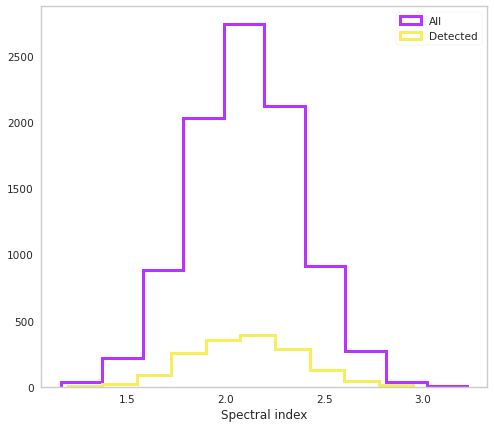

In [11]:
fig, ax = plt.subplots()
ax.hist(population.index, color=purple, histtype="step", lw=3, label="All")
ax.hist(population.index[population.selection], histtype="step", lw=3, 
        color=yellow, label="Detected")
ax.set_xlabel("Spectral index")
ax.legend()

Let's see the distribution of objects on the sky in Galactic coordinates:

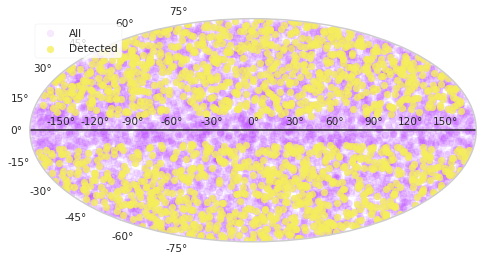

In [12]:
c_all = SkyCoord(population.ra, population.dec, unit="deg", frame="icrs")
c_sel = SkyCoord(population.ra[population.selection], 
                 population.dec[population.selection], unit="deg", frame="icrs",)

fig, ax = plt.subplots(subplot_kw={"projection": "hammer"})
ax.scatter(c_all.galactic.l.rad-np.pi, c_all.galactic.b.rad, alpha=0.1, 
           color=purple, label="All")
ax.scatter(c_sel.galactic.l.rad-np.pi, c_sel.galactic.b.rad, alpha=0.8, 
           color=yellow, label="Detected")
ax.axhline(0, color="k")
ax.legend()

We can now imagine that by changing the input parameters, we can fit our model to the observations in order to have an optimal representation of the true BL Lac blazar population with this parameterizations.